In [1]:
import scipy.interpolate
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyam
import silicone.multiple_infillers as mi
import silicone.database_crunchers as dc
import silicone.utils
import sys

<IPython.core.display.Javascript object>

In [2]:
version = "v7"
co2 = "Emissions|CO2"
co2eni = co2+"|Energy and Industrial Processes"
ch4 = "Emissions|CH4"
outdir = f'../output/chosen_files/{version}/'
scen_file = outdir + "scen_{}"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
sys.path.insert(0, '..')

In [4]:
import scripts.utils

In [5]:
ar6 = pyam.IamDataFrame("..\input\AR6_Scenarios_Database_World_v1.0_emissions.csv")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\input\AR6_Scenarios_Database_World_v1.0_emissions.csv


In [6]:
ar6_meta = pd.read_excel(
    "..\input\AR6_Scenarios_Database_metadata_indicators_v1.0.xlsx", 
    sheet_name="Illustrative_Pathways"
)

In [7]:
cent = [2010, 2015] + list(np.arange(2020, 2101, 10))
ar6_meta = ar6_meta.iloc[[x[-3:] != "2.0" for x in ar6_meta["IMP_marker"]]]

In [8]:
ar6_meta = ar6_meta.set_index(["model", "scenario"])
ar6_meta

,,IMP_marker,IMP_notes,IMP_reference
model,scenario,,,
COFFEE 1.1,EN_NPi2020_400f_lowBECCS,Neg,NaN,NGFS Climate Scenarios for central banks and s...
GCAM 5.3,NGFS2_Current Policies,CurPol,NaN,https://doi.org/10.1038/s41560-018-0172-6
IMAGE 3.0,EN_INDCi2030_3000f,ModAct,NaN,https://doi.org/10.1038/s41558-021-01215-2
MESSAGEix-GLOBIOM 1.0,LowEnergyDemand_1.3_IPCC,LD,Scenario name has a whitespace at the end - to...,https://doi.org/10.1038/s41558-021-01215-2
REMIND-MAgPIE 2.1-4.3,DeepElec_SSP2_ HighRE_Budg900,Ren,NaN,https://doi.org/10.1038/s41560-021-00937-z
REMIND-MAgPIE 2.1-4.2,SusDev_SDP-PkBudg1000,SP,NaN,"Guo, F., van Ruijven, B., Zakeri, B., Krey, V...."
WITCH 5.0,CO_Bridge,GS,NaN,https://doi.org/10.1038/s41558-021-01098-3


In [9]:
ar6.set_meta(ar6_meta["IMP_marker"])

In [10]:
imp_scen = ar6.filter(IMP_marker=ar6_meta.IMP_marker)
imp_scen

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : COFFEE 1.1, GCAM 5.3, IMAGE 3.0, ... WITCH 5.0 (7)
 * scenario : EN_NPi2020_400f_lowBECCS, NGFS2_Current Policies, ... CO_Bridge (7)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|CH4, Emissions|CH4|AFOLU, ... Emissions|CO2|Energy|Demand|AFOFI (130)
   unit     : Mt CH4/yr, Mt CO2/yr, Mt CO2-equiv/yr, kt N2O/yr, ... kt C6F14/yr (25)
   year     : 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, ... 2005 (20)
Meta indicators:
   exclude (bool) False (1)
   IMP_marker (object) Neg, CurPol, ModAct, LD, SP, Ren, GS (7)

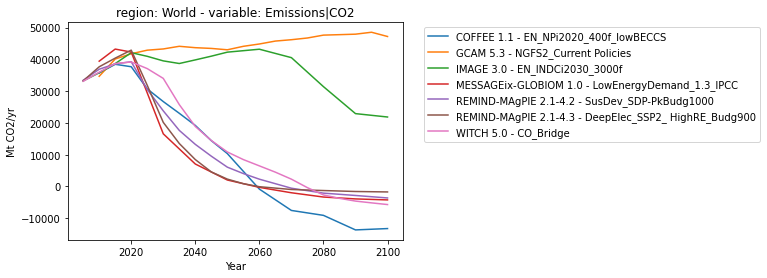

In [11]:
imp_scen.filter(variable=co2).plot()
plt.legend(bbox_to_anchor=(1.05, 1))

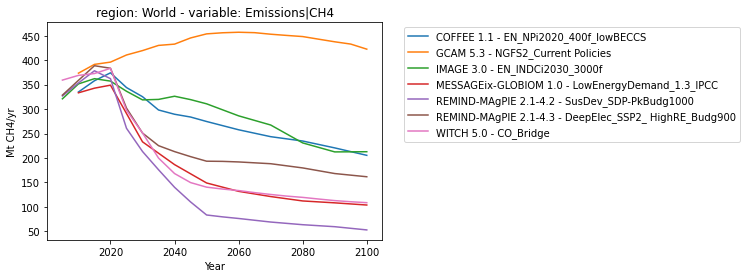

In [12]:
imp_scen.filter(variable=ch4).plot()
plt.legend(bbox_to_anchor=(1.05, 1))

In [13]:
rcmip = pyam.IamDataFrame("../input/rcmip-emissions-annual-means-v5-1-0.csv")

pyam.core - INFO: Reading file ..\input\rcmip-emissions-annual-means-v5-1-0.csv


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM - scenario: ssp245 - region: World - variable: Emissions|CO2 - mip_era: CMIP6 - activity_id: not_applicable'}, xlabel='Year', ylabel='Mt CO2/yr'>

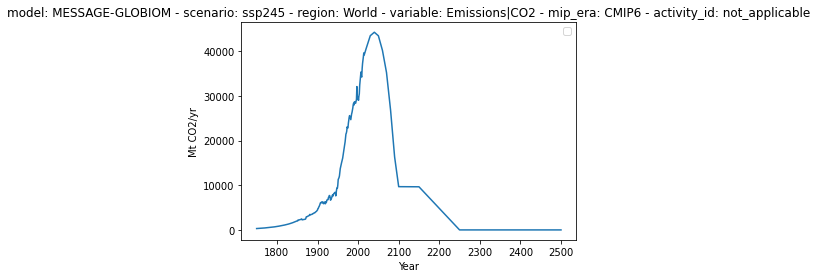

In [14]:
rcmip.filter(scenario="ssp245", variable=co2, region="World").plot()

In [15]:
rcmip.filter(scenario="ssp119")

<class 'pyam.core.IamDataFrame'>
Index:
 * model       : IMAGE (1)
 * scenario    : ssp119 (1)
Timeseries data coordinates:
   region      : World, World|R5.2ASIA, World|R5.2LAM, ... World|R5.2REF (6)
   variable    : Emissions|BC, ... (182)
   unit        : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2/yr, ... kt cC4F8/yr (51)
   year        : 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, ... 2500 (315)
   mip_era     : CMIP6 (1)
   activity_id : not_applicable (1)
Meta indicators:
   exclude (bool) False (1)

In [16]:
useful_years = [y for y in rcmip.year if y>2000]

In [17]:
desired_scenarios = [
    rcmip.filter(model="REMIND-MAGPIE", scenario="ssp534-over", region="World", year=useful_years),
    rcmip.filter(model="IMAGE", scenario="ssp119", region="World", year=useful_years),
]

# Harmonise the emissions
Unfortunately we don't have history from 2015, so we use SSP2-4.5 instead

In [18]:
required_variables_list = [
            "Emissions|BC",
            "Emissions|PFC|CF4",
            "Emissions|PFC|C2F6",
            "Emissions|PFC|C6F14",
            "Emissions|CH4",
            "Emissions|CO2|AFOLU",
            "Emissions|CO2|Energy and Industrial Processes",
            "Emissions|CO",
            "Emissions|HFC|HFC134a",
            "Emissions|HFC|HFC143a",
            "Emissions|HFC|HFC227ea",
            "Emissions|HFC|HFC23",
            "Emissions|HFC|HFC32",
            "Emissions|HFC|HFC43-10",
            "Emissions|HFC|HFC245ca",
            "Emissions|HFC|HFC125",
            "Emissions|N2O",
            "Emissions|NH3",
            "Emissions|NOx",
            "Emissions|OC",
            "Emissions|SF6",
            "Emissions|Sulfur",
            "Emissions|VOC",
        ]

In [19]:
extra_var = [co2, "Emissions|F-Gases"]
ar6 = ar6.filter(variable=required_variables_list + extra_var, year=cent)

In [20]:
ar6 = ar6.interpolate(2015)

In [21]:
hist = ar6.filter(
    scenario="SSP2-45", model = "MESSAGE-GLOBIOM 1.0", year=imp_scen.year, region="World"
)
hist.timeseries()

2010  \
model               scenario region variable                                      unit                            
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|BC                                  Mt BC/yr             7.032940   
                                    Emissions|CH4                                 Mt CH4/yr          326.525263   
                                    Emissions|CO                                  Mt CO/yr           849.797615   
                                    Emissions|CO2                                 Mt CO2/yr        40294.293821   
                                    Emissions|CO2|AFOLU                           Mt CO2/yr         7161.443786   
                                    Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        33132.850034   
                                    Emissions|F-Gases                             Mt CO2-equiv/yr    733.216000   
                                    Emissions|HFC|HFC125                          kt HFC125/yr        31.108948   
                                    Emissions|HFC|HFC134a                         kt HFC134a/yr      153.603976   
                                    Emissions|HFC|HFC143a                         kt HFC143a/yr       19.299299   
                                    Emissions|HFC|HFC227ea                        kt HFC227ea/yr       2.364525   
                                    Emissions|HFC|HFC23                           kt HFC23/yr          9.271299   
                                    Emissions|HFC|HFC32                           kt HFC32/yr         14.785264   
                                    Emissions|HFC|HFC43-10                        kt HFC43-10/yr       0.804910   
                                    Emissions|N2O                                 kt N2O/yr         8758.092223   
                                    Emissions|NH3                                 Mt NH3/yr           55.391078   
                                    Emissions|NOx                                 Mt NO2/yr          111.932782   
                                    Emissions|OC                                  Mt OC/yr            32.779500   
                                    Emissions|SF6                                 kt SF6/yr            7.584003   
                                    Emissions|Sulfur                              Mt SO2/yr          100.029929   
                                    Emissions|VOC                                 Mt VOC/yr          187.800360   

                                                                                                           2015  \
model               scenario region variable                                      unit                            
MESSAGE-GLOBIOM 1.0 SSP2-45  World  Emissions|BC                                  Mt BC/yr             6.491703   
                                    Emissions|CH4                                 Mt CH4/yr          331.179148   
                                    Emissions|CO                                  Mt CO/yr           817.693954   
                                    Emissions|CO2                                 Mt CO2/yr        41289.611277   
                                    Emissions|CO2|AFOLU                           Mt CO2/yr         6415.915892   
                                    Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        34873.695386   
                                    Emissions|F-Gases                             Mt CO2-equiv/yr   1113.405333   
                                    Emissions|HFC|HFC125                          kt HFC125/yr        81.899172   
                                    Emissions|HFC|HFC134a                         kt HFC134a/yr      192.838013   
                                    Emissions|HFC|HFC143a                         kt HFC143a/yr       37.845897   
                                    Emissions|HFC|HFC227ea                       

<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - scenario: SSP2-45 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

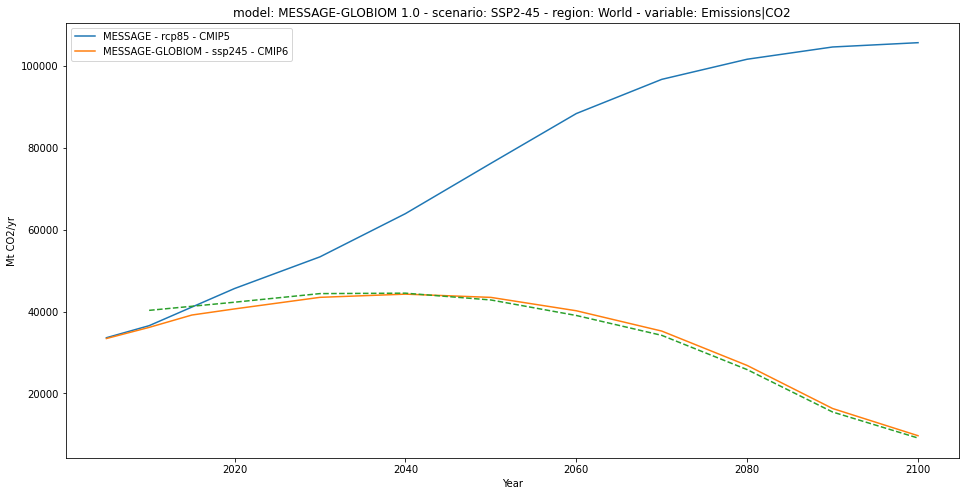

In [22]:
plt.figure(figsize=(16, 8))
ax = plt.subplot()
rcmip.filter(model="MESSAGE*", year=imp_scen.year,variable=co2,region="World").plot(ax=ax)
ar6.filter(scenario="SSP2-45", model="MESSAGE*", year=imp_scen.year,variable=co2,region="World").plot(ax=ax, linestyle="--")

In [23]:
hist.model

['MESSAGE-GLOBIOM 1.0']

In [24]:
# Harmonise using a scaling factor that goes to 1 in 2050
unity_year = 2050
def harmonize(df, var, harm_df, harm_years):
    harm_unit = harm_df.filter(variable=var).unit
    to_harm_unit = df.filter(variable=var).unit
    assert (harm_unit == to_harm_unit) or (harm_unit == ["Mt CO2-equiv/yr"]) or (
        (harm_unit == ["Mt NOx/yr"]) and (to_harm_unit == ["Mt NO2/yr"])
    ), "Invalid units {} (desired) and {} (current) for variable {}".format(
        harm_unit, to_harm_unit, var
    )
    if (harm_unit != to_harm_unit):
        print(
            "unit mismatch for  {} (desired) and {} (current) for variable {}".format(harm_unit, to_harm_unit, var)
        )
        if (harm_unit == ["Mt CO2-equiv/yr"]):
            df = pyam.convert_unit(df, current=to_harm_unit[0], to=harm_unit[0], context="AR4GWP100")
        print("Converted unit of {} to {}".format(var, df.filter(variable=var).unit))
    assert unity_year >= max(harm_years)
    canon2015 = harm_df.filter(year=2015, variable=var).data["value"]
    if len(canon2015) != 1:
        print(canon2015)
        raise ValueError
    ret = df.timeseries()
    canon2015 = canon2015[0]
    canon2010 = harm_df.filter(year=2010, variable=var).data["value"][0]
    if 2005 in harm_df.year:
        canon2005 = harm_df.filter(year=2005, variable=var).data["value"][0]
        ret[2005] = canon2005
    if 2000 in harm_df.year:
        canon2000 = harm_df.filter(year=2000, variable=var).data["value"][0]
        ret[2000] = canon2000
    assert df.variable==[var]
    ret[2010] = canon2010
    fractional_correction_all = ret[2015] / canon2015
    fractional_correction_use = fractional_correction_all
    ret[2015] = canon2015
    for year in [y for y in harm_years if y > 2015]:
        ret[year] = ret[year] / fractional_correction_use
        # Each decade we advance the harmonisation towards 1 linearly.
        next_year = min([y for y in harm_years if y > year] + [1000000])
        fractional_correction_use = 1 - (1-fractional_correction_all) * (unity_year - next_year) / (unity_year-2015)
    
    return pyam.IamDataFrame(ret)

In [25]:
harm_years = [y for y in imp_scen.year if y <= unity_year]
imp_scen_harm = []
unavailable_vars = []
for var in required_variables_list + extra_var:
    if imp_scen.filter(variable=var).empty or hist.filter(variable=var).empty:
        print(f"No data avaiable for {var}")
        unavailable_vars.append(var)
        continue
    tmp = harmonize(imp_scen.filter(variable=var), var, hist, harm_years)
    imp_scen_harm.append(tmp)

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


No data avaiable for Emissions|PFC|CF4
No data avaiable for Emissions|PFC|C2F6
No data avaiable for Emissions|PFC|C6F14


pyam.core - WARNING: Filtered IamDataFrame is empty!


No data avaiable for Emissions|HFC|HFC245ca


# Infill the missing emissions

In [26]:
df = pyam.concat(desired_scenarios)

In [27]:
df = df.data
del df["activity_id"]
del df["mip_era"]

In [28]:
hfcs = [
    "Emissions|HFC|HFC125", "Emissions|HFC|HFC134a", "Emissions|HFC|HFC143a",
    "Emissions|HFC|HFC227ea", "Emissions|HFC|HFC23", "Emissions|HFC|HFC32", "Emissions|HFC|HFC43-10",
]
fgases = ["Emissions|HFC", "Emissions|SF6", 'Emissions|PFC|C2F6', 'Emissions|PFC|CF4']
fgas = "Emissions|F-Gases"

In [29]:
df["variable"] = df["variable"].str.replace("MAGICC AFOLU", "AFOLU").str.replace(
    "MAGICC Fossil and Industrial", "Energy and Industrial Processes"
)

In [30]:
df = pyam.IamDataFrame(df)

In [31]:
df2 = pyam.concat(imp_scen_harm)

In [32]:
# Rename the scenarios for convenience
df2 = df2.data
for (_, (old, new)) in ar6_meta.reset_index()[["scenario", "IMP_marker"]].iterrows():
    df2.loc[df2["scenario"]==old, "scenario"] = new
df2 = pyam.IamDataFrame(df2)

In [33]:
df2.scenario

['CurPol', 'GS', 'LD', 'ModAct', 'Neg', 'Ren', 'SP']

In [34]:
df = df.append(df2)

In [35]:
missing_emissions = [
    'Emissions|PFC|C2F6', 'Emissions|HFC|HFC43-10', 'Emissions|PFC|C6F14', 'Emissions|HFC|HFC125', 
    'Emissions|HFC|HFC32', 'Emissions|HFC|HFC143a', 'Emissions|HFC|HFC245fa', 'Emissions|HFC|HFC23', 
    'Emissions|HFC|HFC134a', 'Emissions|SF6', 'Emissions|PFC|CF4', 'Emissions|HFC|HFC227ea', 
]

In [36]:
added_var = []
for em in missing_emissions:
    is_empty = ar6.filter(region="World", variable=em).empty
    if is_empty:
        added_var.append(em)
        print(em)

pyam.core - WARNING: Filtered IamDataFrame is empty!


Emissions|HFC|HFC245fa


In [37]:
normal_years = [2015] + list(np.arange(2020, 2101, 10))
infilled_df = mi.infill_all_required_variables(
    df.filter(region="World", year=normal_years),
    ar6.filter(region="World"), 
    [co2],
    required_variables_list=required_variables_list + added_var
)

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:191: UserWarning: No data for ['Emissions|HFC|HFC245ca', 'Emissions|HFC|HFC245fa'], it will be infilled with 0s
  unavailable_variables
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables:   0%|                                                                | 0/2 [00:00<?, ?it/s]silicone.database_crunchers.constant_ratio - WARNING: Note that the lead variable ['Emissions|CO2'] goes negative.
silicone.database_crunchers.constant_ratio - WARNING: Note that the lead variable ['Emissions|CO2'] goes negative.
Filling required variables: 100%|████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.77it/s]


Note that the lead variable ['Emissions|CO2'] goes negative.
Note that the lead variable ['Emissions|CO2'] goes negative.


Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:07<00:00,  2.97it/s]


In [38]:
df_inf = df.filter(year=np.arange(2000, 2101), keep=False).append(infilled_df)
bad_vars = [
    "*Sulfur|*", "*|BC|*", "*CH4|*", "Emissions|Montreal Gases|*", "Emissions|VOC|*", 
    "Emissions|NH3|*", "Emissions|NOx|*", "Emissions|OC|*", "Emissions|CO|*", 
]

In [39]:
extra_years = np.arange(2110, 2301, 10)
dfts = df_inf.timeseries()
for year in extra_years:
    blanks = np.isnan(dfts.loc[:, year])
    dfts.loc[blanks, year] = dfts.loc[blanks, 2100]

In [40]:
dfts

2015  \
model      scenario region variable            unit                        
COFFEE 1.1 Neg      World  Emissions|BC        Mt BC/yr         7.311049   
                           Emissions|CH4       Mt CH4/yr      331.179148   
                           Emissions|CO        Mt CO/yr       847.398056   
                           Emissions|CO2       Mt CO2/yr    41289.611277   
                           Emissions|CO2|AFOLU Mt CO2/yr     6415.915892   
...                                                                  ...   
WITCH 5.0  GS       World  Emissions|PFC|C6F14 kt C6F14/yr      1.310339   
                           Emissions|PFC|CF4   kt CF4/yr       12.131953   
                           Emissions|SF6       kt SF6/yr        7.718131   
                           Emissions|Sulfur    Mt SO2/yr       88.404937   
                           Emissions|VOC       Mt VOC/yr      182.816450   

                                                                    2020  \
model      scenario region variable            unit                        
COFFEE 1.1 Neg      World  Emissions|BC        Mt BC/yr         7.235187   
                           Emissions|CH4       Mt CH4/yr      346.121739   
                           Emissions|CO        Mt CO/yr       800.019862   
                           Emissions|CO2       Mt CO2/yr    40461.665900   
                           Emissions|CO2|AFOLU Mt CO2/yr     6862.540446   
...                                                                  ...   
WITCH 5.0  GS       World  Emissions|PFC|C6F14 kt C6F14/yr      0.923039   
                           Emissions|PFC|CF4   kt CF4/yr       10.736830   
                           Emissions|SF6       kt SF6/yr        7.359764   
                           Emissions|Sulfur    Mt SO2/yr       88.053166   
                           Emissions|VOC       Mt VOC/yr      170.213072   

                                                                    2030  \
model      scenario region variable            unit                        
COFFEE 1.1 Neg      World  Emissions|BC        Mt BC/yr         5.716334   
                           Emissions|CH4       Mt CH4/yr      310.934029   
                           Emissions|CO        Mt CO/yr       700.400701   
                           Emissions|CO2       Mt CO2/yr    27809.679418   
                           Emissions|CO2|AFOLU Mt CO2/yr     1080.300339   
...                                                                  ...   
WITCH 5.0  GS       World  Emissions|PFC|C6F14 kt C6F14/yr      0.937891   
                           Emissions|PFC|CF4   kt CF4/yr        9.941279   
                           Emissions|SF6       kt SF6/yr        5.596192   
                           Emissions|Sulfur    Mt SO2/yr       63.992152   
                           Emissions|VOC       Mt VOC/yr      150.912734   

                                                                    2040  \
model      scenario region variable            unit                        
COFFEE 1.1 Neg      World  Emissions|BC        Mt BC/yr         4.521496   
                           Emissions|CH4       Mt CH4/yr      282.894483   
                           Emissions|CO        Mt CO/yr       571.102939   
                           Emissions|CO2       Mt CO2/yr    19590.064316   
                           Emissions|CO2|AFOLU Mt CO2/yr     -624.645038   
...                                                                  ...   
WITCH 5.0  GS       World  Emissions|PFC|C6F14 kt C6F14/yr      0.439299   
                           Emissions|PFC|CF4   kt CF4/yr        4.880410   
                           Emissions|SF6       kt SF6/yr        4.679184   
                           Emissions|Sulfur    Mt SO2/yr       29.892739   
                           Emissions|VOC       Mt VOC/yr      122.756701   

                                                                    2050  \
model      scenario region variable 

In [41]:
extended_df = pyam.IamDataFrame(dfts)

In [42]:
extended_df.scenario

['CurPol', 'GS', 'LD', 'ModAct', 'Neg', 'Ren', 'SP', 'ssp119', 'ssp534-over']

# Add in addional scenarios

In [43]:
# We can judge the highest possible overshoot decay rate from this scenario
overshoot = extended_df.filter(scenario="*ov*", variable=co2eni).timeseries()
max_overshoot_dif = max(max(abs(overshoot.iloc[:, 2:].values - overshoot.iloc[:, 1:-1].values)))
max_overshoot_dif

35753.336989999996

In [44]:
extended_df = extended_df.filter(variable=co2, keep=False)

In [45]:
neg_scen_data = extended_df.filter(year=2100, scenario="Neg").filter(variable=co2eni, keep=False).timeseries()
negscenvar = extended_df.filter(year=2100, scenario="Neg").variable
neg_scen_data

2100
model      scenario region variable               unit                        
COFFEE 1.1 Neg      World  Emissions|BC           Mt BC/yr            1.712026
                           Emissions|CH4          Mt CH4/yr         205.464330
                           Emissions|CO           Mt CO/yr          306.325518
                           Emissions|CO2|AFOLU    Mt CO2/yr        -116.564100
                           Emissions|HFC|HFC125   kt HFC125/yr       26.201235
                           Emissions|HFC|HFC134a  kt HFC134a/yr      69.337875
                           Emissions|HFC|HFC143a  kt HFC143a/yr      21.790826
                           Emissions|HFC|HFC227ea kt HFC227ea/yr      0.363249
                           Emissions|HFC|HFC23    kt HFC23/yr         0.000000
                           Emissions|HFC|HFC245ca Mt CO2-equiv/yr    -0.000000
                           Emissions|HFC|HFC245fa Mt CO2-equiv/yr    -0.000000
                           Emissions|HFC|HFC32    kt HFC32/yr        11.844943
                           Emissions|HFC|HFC43-10 kt HFC43-10/yr      0.940103
                           Emissions|N2O          kt N2O/yr        4057.138950
                           Emissions|NH3          Mt NH3/yr          45.057245
                           Emissions|NOx          Mt NO2/yr          41.629411
                           Emissions|OC           Mt OC/yr           11.993805
                           Emissions|PFC|C2F6     kt C2F6/yr          0.136386
                           Emissions|PFC|C6F14    kt C6F14/yr         0.097687
                           Emissions|PFC|CF4      kt CF4/yr           2.864589
                           Emissions|SF6          kt SF6/yr           1.055914
                           Emissions|Sulfur       Mt SO2/yr           9.922866
                           Emissions|VOC          Mt VOC/yr          73.083545

In [46]:
new_scens = []
value_lims_map = {"CurPol": [-24000], "ModAct": [-23000, -17000], "Neg": [-17000]}
for base_scen in ["CurPol", "ModAct", "Neg"]:
    curpol_nz_base = extended_df.filter(
        scenario=base_scen, variable=negscenvar
    ).filter(variable=co2eni, keep=False).timeseries().reset_index()
    curpol_nz_co2_base = extended_df.filter(
        scenario=base_scen, variable=co2eni
    ).timeseries().reset_index()
    allindexcols = ["model", "scenario", "region", "variable", "unit"]
    if base_scen != "Neg":
        nzdate = 2120
    else:
        nzdate = 2100
    yeargap = 10
    gradient_lim = max_overshoot_dif / yeargap
    
    for value_lim in value_lims_map[base_scen]:
        curpol_nz = curpol_nz_base.copy()
        assert np.array_equal(curpol_nz["variable"].values, neg_scen_data.index.get_level_values("variable"))
        curpol_nz_co2 = curpol_nz_co2_base.copy()
        curpol_nz["scenario"] = f"{base_scen} nz {nzdate} decline {value_lim}"
        curpol_nz_co2["scenario"] = curpol_nz["scenario"].iloc[0]
        curpol_nz_co2 = curpol_nz_co2.set_index(allindexcols)
        curpol_nz = curpol_nz.set_index(allindexcols)
        curpol_nz_co2_2100 = curpol_nz_co2.loc[:, 2100]
        for year in np.arange(2110, nzdate + 1, yeargap):
            curpol_nz_co2.loc[:, year] = curpol_nz_co2_2100 * (1 - (year - 2100) / (nzdate - 2100))
            curpol_nz.loc[:, year] = (curpol_nz.loc[:, 2100].values * (nzdate - year) + 
                                      neg_scen_data[2100].values * (year - 2100)) / (nzdate - 2100)
        prev_year = nzdate
        postnz = [c for c in  curpol_nz_co2.columns if c > nzdate]
        for year in postnz:
            curpol_nz[year] = neg_scen_data.values
            curpol_nz_co2[year] = np.maximum(curpol_nz_co2[prev_year] - gradient_lim * yeargap, value_lim)
            prev_year = year
        curpol_nz_co2.loc[curpol_nz_co2.index.get_level_values("variable")==co2+"|AFOLU", postnz] = 0
        new_scens.append(curpol_nz.append(curpol_nz_co2))

In [47]:
# Modify scenarios where we want net-zero conditions.
nz_co2only_post2100 = ["Ren"]
nz_allghgh_post2100 = ["LD", "SP", "GS"]
ghgs = [co2 + "*", ch4 + "*", "*F-Gases*", "*SF6", "*HFC*", "*PFC*", "*N2O*"]
zerodvars = []
for scen in nz_co2only_post2100:
    co2_comp = extended_df.filter(scenario=scen, variable=co2eni).timeseries()
    co2_comp.loc[:, [c for c in co2_comp.columns if c > 2100]] = 0
    zerodvars.append(co2_comp)
for scen in nz_allghgh_post2100:
    ghg_comp = extended_df.filter(scenario=scen, variable=ghgs).timeseries()
    ghg_comp.loc[:, [c for c in ghg_comp.columns if c > 2100]] = 0
    zerodvars.append(ghg_comp)

In [48]:
extended_df = extended_df.filter(scenario=nz_co2only_post2100, variable=co2eni, keep=False).filter(
    scenario=nz_allghgh_post2100, variable=ghgs, keep=False
)

In [49]:
extended_df = extended_df.append(pyam.concat(zerodvars))

In [50]:
curpol_nz_pyam = pyam.concat(new_scens)

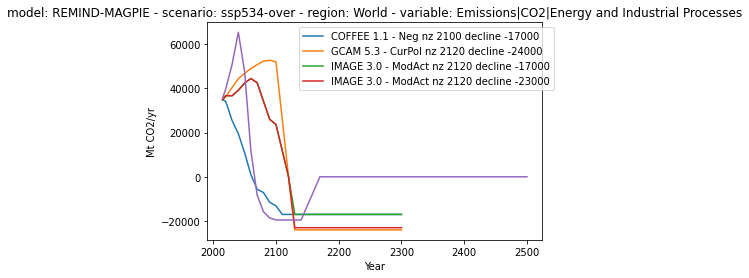

In [51]:
ax = plt.subplot()
curpol_nz_pyam.filter(variable=co2eni).plot(ax=ax)
extended_df.filter(variable=co2eni, scenario="*ov*").plot(ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1))

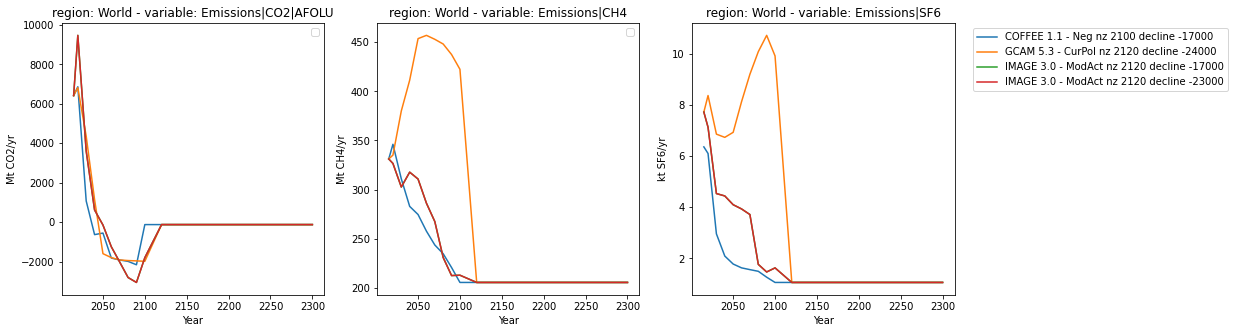

In [52]:
plt.figure(figsize=(16,5))
ax = plt.subplot(131)
curpol_nz_pyam.filter(variable=co2+"|AFOLU").plot(ax=ax)
plt.legend([])
ax = plt.subplot(132)
curpol_nz_pyam.filter(variable=ch4).plot(ax=ax)
plt.legend([])
ax = plt.subplot(133)
curpol_nz_pyam.filter(variable="*SF6").plot(ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1))

In [53]:
extended_df = extended_df.append(curpol_nz_pyam)

In [54]:
extended_df.scenario

['CurPol',
 'CurPol nz 2120 decline -24000',
 'GS',
 'LD',
 'ModAct',
 'ModAct nz 2120 decline -17000',
 'ModAct nz 2120 decline -23000',
 'Neg',
 'Neg nz 2100 decline -17000',
 'Ren',
 'SP',
 'ssp119',
 'ssp534-over']

pyam.plotting - INFO: >=13 labels, not applying legend


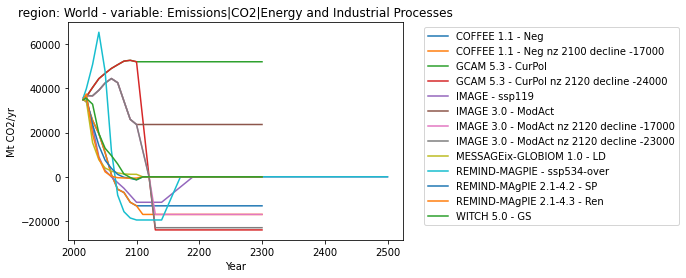

In [55]:
extended_df.filter(variable=co2eni).plot()
plt.legend(bbox_to_anchor=(1.05, 1))

In [60]:
# Then append the net zero GHG scenarios
nzghg_scens = []
for scenario in ["GS", "Neg", "SP"]:
    clone = extended_df.filter(scenario=scenario).copy()
    ghgtot = silicone.utils._construct_consistent_values(
        "Kyoto GHG total (AR6GWP100)", ghgs, silicone.utils.convert_units_to_MtCO2_equiv(
            clone.filter(variable=ghgs).rename({"unit":{'kt HFC43-10/yr': 'kt HFC4310/yr'}}), metric_name="AR5GWP100")
    ).timeseries()
    # We need to know the last year before the values first go negative and interpolate the value between this and 
    pre_nz_year = ghgtot.columns[(ghgtot>0).cumsum().values.sum()]
    nzyear = int(np.round(scipy.interpolate.interp1d(
        ghgtot.loc[:, pre_nz_year-10: pre_nz_year].iloc[0].values, np.array([pre_nz_year-10, pre_nz_year])
    )(0)))
    assert nzyear < 2100
    clone = clone.interpolate(nzyear)
    clone = clone.rename({"scenario":{scenario: scenario + "_NZGHG"}}).timeseries()
    for year in [y for y in clone.columns if y > nzyear]:
        clone[year] = clone[nzyear]
    nzghg_scens.append(clone)

In [57]:
extended_df = extended_df.append(pyam.concat(nzghg_scens))

In [66]:
# And one net zero CO2 scenario
clone = extended_df.filter(scenario="Ren").copy()
co2tot = silicone.utils._construct_consistent_values(
    co2, [co2eni, co2 + "|AFOLU"], clone.filter(variable=co2+"*")
).timeseries()
# We need to know the last year before the values first go negative and interpolate the value between this and 
pre_nz_year = co2tot.columns[(co2tot>0).cumsum().values.sum()]
print(pre_nz_year)
nzyear = int(np.round(scipy.interpolate.interp1d(
    co2tot.loc[:, pre_nz_year-10: pre_nz_year].iloc[0].values, np.array([pre_nz_year-10, pre_nz_year])
)(0)))
assert nzyear < 2100
print(nzyear)
clone = clone.interpolate(nzyear)
clone = clone.rename({"scenario":{"Ren": "Ren_NZCO2"}}).timeseries()
for year in [y for y in clone.columns if y > nzyear]:
    clone[year] = clone[nzyear]

2060
2060


In [67]:
extended_df = extended_df.append(clone)

In [68]:
for scenario in extended_df.scenario:
    data = extended_df.filter(
            scenario=scenario, variable="Emissions|*", year=normal_years+list(extra_years)
        ).filter(
            variable=bad_vars, keep=False
        )
    scripts.utils.construct_scen_file(
        data, 
        scen_file.format(scenario)
    )

In [69]:
scen_file

'../output/chosen_files/v7/scen_{}'